In [1]:
# import library for Support Vector Classification
from sklearn.svm import SVC

# import library for plot
import matplotlib.pyplot as plt

# import library for data handling
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import math

# import library for pytorch
import torch
import torch.nn as nn

# import custom function
from stock_predict import SequenceDataset, ShallowRegressionLSTM, train, test, get_stock_data, split_train_test, predict, svm_train

# Get cuda device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# predict df
predict_df = pd.DataFrame(columns = ["High", "Low", "Open", "Close"])

/home/victoru/anaconda3/envs/testpython/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Get the past stock price
df = get_stock_data(stock_name = 'TSLA', source = 'yahoo', past_year = 2)


In [3]:
pred_list = ["High", "Low", "Open", "Close"]

In [4]:
def run(df,training_target):

    # Split data into train and test
    train_df, test_df, feature, target, train_size, test_size, target_mean, target_std = split_train_test(training_target = training_target, df = df, train_ratio = 0.8)

    # create dataset and data loader
    batch_size = 4
    seq_len = 60

    torch.manual_seed(seq_len*batch_size/2)

    train_dataset = SequenceDataset(train_df, target, feature, seq_len)
    test_dataset = SequenceDataset(test_df, target, feature, seq_len)
    train_looader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # get the first batch and its shape
    x, y = next(iter(train_looader))
    print("Features shape: ", x.shape)
    print("Target shape: ", y.shape)

    # create model, loss and optimizer
    learning_rate = 5e-5
    num_hidden = 16
    epochs = 40

    model = ShallowRegressionLSTM(n_features = len(feature), n_hidden = num_hidden, device=device).to(device)
    loss = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # train and test model
    print("Untrained test\n----------------")
    test(model, test_loader, loss, device)
    print("\nTraining\n----------------")

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}\n")
        train(model, train_looader, loss, optimizer, device)
        test(model, test_loader, loss, device)

    train_eval = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

    prediction = f"{target}_pred"
    train_df[prediction] = predict(train_eval, model, device)
    test_df[prediction] = predict(test_loader, model, device)

    df_out = pd.concat([train_df, test_df], axis=0)[[target, prediction]]

    for c in df_out.columns:
        df_out[c] = df_out[c] * target_std + target_mean
    
    return df_out


In [5]:
df_pred = pd.DataFrame()
for training_target in pred_list:
    print(f"Training target: {training_target}")
    df_out = run(df,training_target)
    df_pred = pd.concat([df_pred, df_out], axis=1)

Training target: High
Features shape:  torch.Size([4, 60, 5])
Target shape:  torch.Size([4])
Untrained test
----------------
Test loss: 0.3720

Training
----------------
Epoch 1

Train loss: 1.0055
Test loss: 0.3449
Epoch 2

Train loss: 0.9545
Test loss: 0.3173
Epoch 3

Train loss: 0.9024
Test loss: 0.2892
Epoch 4

Train loss: 0.8466
Test loss: 0.2607
Epoch 5

Train loss: 0.7910
Test loss: 0.2300
Epoch 6

Train loss: 0.7348
Test loss: 0.1985
Epoch 7

Train loss: 0.6685
Test loss: 0.1649
Epoch 8

Train loss: 0.5986
Test loss: 0.1305
Epoch 9

Train loss: 0.5300
Test loss: 0.0993
Epoch 10

Train loss: 0.4649
Test loss: 0.0717
Epoch 11

Train loss: 0.4070
Test loss: 0.0524
Epoch 12

Train loss: 0.3589
Test loss: 0.0414
Epoch 13

Train loss: 0.3174
Test loss: 0.0370
Epoch 14

Train loss: 0.2844
Test loss: 0.0376
Epoch 15

Train loss: 0.2572
Test loss: 0.0416
Epoch 16

Train loss: 0.2357
Test loss: 0.0466
Epoch 17

Train loss: 0.2140
Test loss: 0.0519
Epoch 18

Train loss: 0.1968
Test loss: 

In [6]:
df_pred = pd.concat([df['Close'], df_pred], axis=1)

In [7]:
svm_model = svm_train(df)

In [8]:
# drop the last row of df_pred
df_pred = df_pred[:-1]

In [9]:

df_pred['High-Low_pred'] = df_pred['High_t+1_pred'] - df_pred['Low_t+1_pred']
df_pred['Open-Close_pred'] = df_pred['Open_t+1_pred'] - df_pred['Close_t+1_pred']

df_pred['High-Low'] = df_pred['High_t+1'] - df_pred['Low_t+1']
df_pred['Open-Close'] = df_pred['Open_t+1'] - df_pred['Close_t+1']

# Make prediction based on LSTM out ,actual stock price and random decision
df_pred["pred_action"] = svm_model.predict(df_pred[['High-Low_pred', 'Open-Close_pred']])
df_pred["action"] = svm_model.predict(df_pred[['High-Low', 'Open-Close']])
df_pred['random'] = np.random.randint(0,2, len(df_pred))

# Calculate the daily returns from the stock
df_pred['returns'] = df_pred['Close'].pct_change(1)

# Calculate the strategy returns
df_pred['strategy_returns'] = df_pred['action'].shift(1) * df_pred['returns']

# Calculate the LSTM based strategy returns
df_pred['LSTM_returns'] = df_pred['pred_action'].shift(1) * df_pred['returns']

# Calculate the random strategy returns
df_pred['random_returns'] = df_pred['random'].shift(1) * df_pred['returns']


# Calculate the cumulative strategy returns
df_pred['cum_strategy_returns'] = (df_pred['strategy_returns'] + 1).cumsum()

# Calculate the cumulative LSTM based strategy returns
df_pred['cum_LSTM_returns'] = (df_pred['LSTM_returns'] + 1).cumsum()

# Calculate the cumulative random returns
df_pred['cum_random_returns'] = (df_pred['random_returns'] + 1).cumsum()

# Calculate the cumulative stock returns
df_pred['cum_stock_returns'] = (df_pred['returns'] + 1).cumsum()


/home/victoru/anaconda3/envs/testpython/lib/python3.10/site-packages/sklearn/base.py:488: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- High-Low_pred
- Open-Close_pred
Feature names seen at fit time, yet now missing:
- High-Low
- Open-Close

  warnings.warn(message, FutureWarning)
/home/victoru/anaconda3/envs/testpython/lib/python3.10/site-packages/sklearn/base.py:488: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


In [10]:
df_pred[['pred_action', 'action', 'random']]

,pred_action,action,random
Date,,,
2020-09-16,1,1,1
2020-09-17,1,1,0
2020-09-18,1,1,1
2020-09-21,1,1,1
2020-09-22,1,1,1
...,...,...,...
2022-09-09,1,1,0
2022-09-12,1,1,1
2022-09-13,1,1,1


In [12]:
df_pred[['High-Low_pred', 'Open-Close_pred', 'High-Low', 'Open-Close']]

,High-Low_pred,Open-Close_pred,High-Low,Open-Close
Date,,,,
2020-09-16,14.371887,3.108002,9.929993,-2.609985
2020-09-17,13.780914,2.458633,7.399994,1.930008
2020-09-18,14.122360,1.753754,16.203323,1.246674
2020-09-21,15.456421,-0.229889,6.720001,1.789993
2020-09-22,17.151413,1.201340,12.089996,8.266663
...,...,...,...,...
2022-09-09,15.415985,-1.210022,5.089996,-3.700012
2022-09-12,15.294281,-1.357422,7.000000,0.769989
2022-09-13,14.969543,-1.753387,14.359985,-10.369995


In [13]:
df_pred[['High_t+1_pred', 'Low_t+1_pred', 'Open_t+1_pred', 'Close_t+1_pred', 'High_t+1', 'Low_t+1', 'Open_t+1', 'Close_t+1']]

,High_t+1_pred,Low_t+1_pred,Open_t+1_pred,Close_t+1_pred,High_t+1,Low_t+1,Open_t+1,Close_t+1
Date,,,,,,,,
2020-09-16,172.335724,157.963837,153.351654,150.243652,145.929993,136.000000,138.533340,141.143326
2020-09-17,171.731995,157.951080,152.524078,150.065445,150.333328,142.933334,149.313339,147.383331
2020-09-18,172.392822,158.270462,151.858765,150.105011,151.893326,135.690002,151.043335,149.796661
2020-09-21,175.181274,159.724854,150.659744,150.889633,145.919998,139.199997,143.199997,141.410004
2020-09-22,175.391968,158.240555,153.108307,151.906967,137.383331,125.293335,135.053329,126.786667
...,...,...,...,...,...,...,...,...
2022-09-09,299.177063,283.761078,289.895630,291.105652,305.489990,300.399994,300.720001,304.420013
2022-09-12,304.964539,289.670258,294.442352,295.799774,297.399994,290.399994,292.899994,292.130005
2022-09-13,306.132751,291.163208,296.985596,298.738983,306.000000,291.640015,292.239990,302.609985


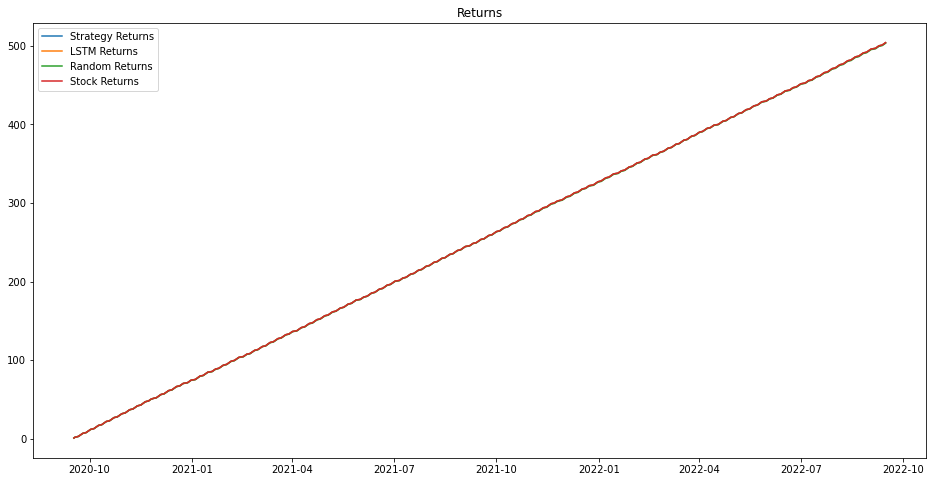

In [11]:
# plot the cumulative returns
plt.figure(figsize=(16,8))
plt.title('Returns')
plt.plot(df_pred['cum_strategy_returns'], label='Strategy Returns')
plt.plot(df_pred['cum_LSTM_returns'], label='LSTM Returns')
plt.plot(df_pred['cum_random_returns'], label='Random Returns')
plt.plot(df_pred['cum_stock_returns'], label='Stock Returns')
plt.legend()
plt.show()